In [9]:
#my stuff
import icu_data_defs
import transformers
import utils
import features
from constants import column_names,variable_type,clinical_source
import units
import mimic
import logger

#other stuff
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin,BaseEstimator,clone

#make pretty pictures
import seaborn as sns
%matplotlib inline

#Every time...
random_state=42

In [61]:
#HELPER FUNCTIONS

def run_crossval(pipeline,X,y):
    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=10)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error',cv=10)

    print 'Cross Validation, K-Fold'
    print 'R^2: {}, {}, {}'.format(scores_r2.mean(),scores_r2.std(),list(scores_r2))
    print 'RMSE: {}, {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std(),list(scores_nmse))

    cv_shuffle = ShuffleSplit(n_splits=10,test_size=0.1)

    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=cv_shuffle)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error', cv=cv_shuffle)

    print '\nCross Validation, ShuffleSplit'
    print 'R^2: {}, {}, {}'.format(scores_r2.mean(),scores_r2.std(),list(scores_r2))
    print 'RMSE: {}, {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std(),list(scores_nmse))
    return

"""
Visualize data
"""
#Visualize
def viz_per_feature(df_features,df_labels):  
    plot_cnt = len(df_labels.columns)+1
    
    df_corr = pd.DataFrame(index=df_features.columns,columns=df_labels.columns)
    
    for i,col_name in enumerate(df_features.columns):
        print col_name,'{}/{}'.format(i,df_features.shape[1])
        col = df_features.loc[:,col_name]
        display(col.describe().apply(lambda x: '%.4f' % x).to_frame())
        #determine # of filled values
        mode = col.mode()[0]
        print mode
        mode_count = (col == mode).sum()
        print "MODE:",mode
        print mode_count
        print mode_count/float(col.shape[0])


        # plot histogram of column (all of df_train)
        fig, axarr  = plt.subplots(1,plot_cnt,figsize=(5*(plot_cnt), 5))
        ax = plt.subplot(1, plot_cnt, 1)
        std = col.std()
        mean = col.mean()
        col.loc[(col < (mean + 3.0*std)) & (col > (mean - 3.0*std))].hist()
        ax.set_title('{}_{}\n{}'.format(col_name[0],col_name[1],col_name[2:]))
        ax.set_xlabel(col_name[-2])
        ax.set_ylabel('COUNT')

        #plot this column vs. each label
        for i,label_name in enumerate(df_labels.columns):
            y = df_labels.loc[:,label_name].dropna()
            
            x = col.loc[y.index]
            ax = plt.subplot(1, plot_cnt, 2+i)
            sns.regplot(x, y)
            corr = np.corrcoef(x, y)[0][1]
            ax.set_title('{}_{} vs. {} \n PCC (r) = {}'.format(col_name[0],col_name[1],label_name[0],corr))
            df_corr.loc[col_name,label_name]=corr
            ax.set_xlabel(col_name[-2])
            ax.set_ylabel(label_name)
        
        plt.tight_layout()
        plt.show()
    
    return df_corr
        
"""
Test/train/validate split
"""

def test_train_val_split(all_ids=None,test_size=0.1,random_state=42,print_ids=False):

    if all_ids is None:
        all_ids = mimic.get_all_hadm_ids()
    
    validate_size = test_size/(1-test_size)
    train_size = (1-test_size)*(1-validate_size)
    #these test IDs will never be touched again. They are sacred
    train_val_ids,test_ids = train_test_split(all_ids,test_size=test_size,random_state=random_state)
    train_ids,validate_ids = train_test_split(train_val_ids,test_size=validate_size,random_state=random_state)

    if print_ids:
        print 'Train {}:'.format(int(train_size*100)), len(train_ids),'>',train_ids[:5],'...'
        print 'Validate {}:'.format(int(train_size*100)), len(validate_ids),'>',validate_ids[:5],'...'
        print 'Test {}:'.format(int(test_size*100)), len(test_ids),'>',test_ids[:5],'...'
    return train_ids,validate_ids,test_ids

# Set up

## ETL

In [62]:
# Load Our Data Dict
data_dict = icu_data_defs.data_dictionary('config/data_definitions.xlsx')
display(data_dict.get_defs())

#init ETL Manager => mimic_extract data
etl_fname = 'data/mimic_extract.h5'
etl_manager = mimic.MimicETLManager(etl_fname,'config/mimic_item_map.csv',data_dict)

,component,units,variable_type,clinical_source,lower,upper,list_id
def_id,,,,,,,
0,heart rate,beats/min,qn,observation,0.0,500.0,NaN
1,blood pressure systolic,mmHg,qn,observation,0.0,500.0,NaN
2,blood pressure diastolic,mmHg,qn,observation,0.0,500.0,NaN
3,blood pressure mean,mmHg,qn,observation,0.0,500.0,NaN
4,respiratory rate,insp/min,qn,observation,0.0,150.0,NaN
5,temperature body,degF,qn,observation,0.0,150.0,NaN
6,oxygen saturation pulse oximetry,percent,qn,observation,0.0,100.0,NaN
7,weight body,kg,qn,observation,0.0,700.0,NaN
8,output urine,mL,qn,observation,0.0,30000.0,NaN


In [64]:
etl_data = etl_manager.etl(components=data_dict.get_components(),save_steps=True) #all components in data dictionary

In [ ]:
etl_data = etl_data.set_index('component')

In [ ]:
etl_data.sort_values('CLEANED_data_count',ascending=False)

## Feature Generation

In [8]:
reload(features)
reload(transformers)

<module 'transformers' from 'transformers.pyc'>

In [15]:
random_state=42
#test/train/val split
train_ids,validate_ids,test_ids = test_train_val_split(print_ids=True,random_state=random_state);

#create all features
m_ureg = units.MedicalUreg()
is_summable = lambda x: m_ureg.is_volume(str(x)) or m_ureg.is_mass(str(x))


"""
Data Specs
"""
summable = {
    column_names.VAR_TYPE : variable_type.QUANTITATIVE,
    column_names.COMPONENT : lambda comp: comp not in  [data_dict.components.WEIGHT_BODY],
    column_names.UNITS: is_summable
}

ordinal = {
    column_names.VAR_TYPE : variable_type.ORDINAL
}

quantitative = {
    column_names.VAR_TYPE : variable_type.QUANTITATIVE
}

nominal = {
    column_names.VAR_TYPE : variable_type.NOMINAL
}

"""
FEATURES
"""

F_mean_qn = features.DataSpecsFeaturizer(
    'mean',
    resample_freq=None,
    data_specs=[quantitative],
    fillna_transformer=Pipeline([
            ('ffill',transformers.GroupbyAndFFill(level=column_names.ID)),
            ('fill_mean',transformers.FillerMean())
        ])
                                     
)

F_mean_ord = features.DataSpecsFeaturizer(
    'mean',
    resample_freq=None,
    data_specs=[ordinal],
    fillna_transformer=Pipeline([
            ('ffill',transformers.GroupbyAndFFill(level=column_names.ID)),
            ('fill_mean',transformers.FillerMode())
        ])
                                     
)

F_last = features.DataSpecsFeaturizer(
    agg_func='last',
    resample_freq=None,
    data_specs=[ordinal,quantitative],
    fillna_transformer=Pipeline([
            ('ffill',transformers.GroupbyAndFFill(level=column_names.ID)),
            ('fill_mean',transformers.FillerMean())
        ])
)


F_std = features.DataSpecsFeaturizer(
    'std',
    resample_freq=None,
    data_specs=[ordinal,quantitative],
    fillna_transformer=transformers.FillerZero()
)

F_sum = features.DataSpecsFeaturizer(
    'sum',
    resample_freq=None,
    data_specs=[summable],
    fillna_transformer=transformers.FillerZero()
)

F_count = features.DataSpecsFeaturizer(
    'count',
    resample_freq=None,
    data_specs=[ordinal,quantitative],
    post_processor = transformers.Replacer(0,np.nan),
    fillna_transformer=transformers.FillerZero()
)

F_count_nom = features.DataSpecsFeaturizer(
    'sum',
    resample_freq=None,
    data_specs=[nominal],
    fillna_transformer=transformers.FillerZero()
)

"""
LABELS
"""
qn_lactate_only={
    column_names.COMPONENT : data_dict.components.LACTATE,
    column_names.VAR_TYPE : variable_type.QUANTITATIVE
}
L_next_lac = features.DataSpecsFeaturizer(
    agg_func='first',
    resample_freq=None,
    data_specs=qn_lactate_only,
    post_processor=transformers.TimeShifter(column_names.DATETIME,shift='infer',n=-1)
)

L_delta_lac = features.DataSpecsFeaturizer(
    agg_func='last',
    resample_freq=None,
    data_specs=qn_lactate_only,
    post_processor=Pipeline([
            ('group_by_id',transformers.ToGroupby(level=column_names.ID)),
            ('delta',transformers.Delta())
        ])
)

Train 80: 47180 > [139698, 127590, 178959, 139276, 196600] ...
Validate 80: 5898 > [112338, 107467, 158733, 144544, 115417] ...
Test 10: 5898 > [167957, 164747, 124147, 184424, 136508] ...


## Smaller Data Set

In [16]:
reload(logger)

train_subset = pd.Series(train_ids).sample(frac=0.2, random_state=random_state).sort_values().tolist()

print train_subset[:5], len(train_subset)

[100014L, 100029L, 100039L, 100046L, 100052L] 9436


In [17]:
reload(features)
#with more memory/a better processor, might not need these first 2 cleaning steps until post-processing
combine_like = Pipeline([
        ('drop_small_columns',transformers.remove_small_columns(threshold=1000)),
        ('drop_low_id_count',transformers.record_threshold(threshold=100)),
        ('combine_like_columns',transformers.combine_like_cols())
    ])

drop_low_counts = Pipeline([
        ('row_threshold',transformers.DropNaN(thresh=20)), #this threshold MAY not apply to a larger feature set.
        ('drop_small_columns',transformers.remove_small_columns(threshold=1000)),
        ('drop_low_id_count',transformers.record_threshold(threshold=100))       
    ])

dsf_labels = features.DataSetFactory(
    featurizers=[
        ('NEXT_LACTATE',L_next_lac),
        ('DELTA_LACTATE',L_delta_lac)
    ],
    resample_freq='2H',
    components=[data_dict.components.LACTATE],
    etl_manager = etl_manager,
    pre_processor = combine_like,
    post_processor = transformers.DropNaN(thresh=1) #drop any rows that have NO labels
)

dsf_features = features.DataSetFactory(
    featurizers=[
        ('MEAN_QN',F_mean_qn),
        ('MEAN_ORD',F_mean_ord),
        ('LAST',F_last),
        ('STD',F_std),
        ('SUM',F_sum),
        ('COUNT',F_count),
        ('COUNT_NOMINAL',F_count_nom),
    ],
    resample_freq='2H',
    components=data_dict.get_components(), # simple data
    etl_manager = etl_manager,
    pre_processor = combine_like,
    post_processor = drop_low_counts

)

In [12]:
df_labels = dsf_labels.fit_transform(train_subset)

(2017-08-22 11:41:34) Make Feature Set. id_count=9436, #features=2, components=
(2017-08-22 11:41:34)>> Begin union for 1 transformers
(2017-08-22 11:41:34)>>>> lactate
(2017-08-22 11:41:34)>>>>>> Load data from component: LACTATE
(2017-08-22 11:41:36)<<<<<< --- (2.0s)
(2017-08-22 11:41:36)>>>>>> *fit* Filter columns (remove_small_columns) (28278, 63)
(2017-08-22 11:41:36)<<<<<< --- (0.0s)
(2017-08-22 11:41:36)>>>>>> *transform* Filter columns (remove_small_columns) (28278, 63)
(2017-08-22 11:41:36)<<<<<< --- (0.0s)
(2017-08-22 11:41:36)>>>>>> *fit* Filter columns (record_threshold) (28278, 4)
(2017-08-22 11:41:36)<<<<<< --- (0.0s)
(2017-08-22 11:41:36)>>>>>> *transform* Filter columns (record_threshold) (28278, 4)
(2017-08-22 11:41:36)<<<<<< --- (0.0s)
(2017-08-22 11:41:36)>>>>>> FIT Combine like columns (28278, 4)
(2017-08-22 11:41:36)>>>>>>>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-08-22 11:41:36)<<<<<<<< --- (0.0s)
(2017-08-22 11:41:36)<<<<<< --- (0.0s)
(2017-08-22 11:41:36)>>>>

In [13]:
df_features = dsf_features.fit_transform(train_subset)

(2017-08-22 11:42:07) Make Feature Set. id_count=9436, #features=7, components=
(2017-08-22 11:42:07)>> Begin union for 57 transformers
(2017-08-22 11:42:07)>>>> heart rate
(2017-08-22 11:42:07)>>>>>> Load data from component: HEART RATE
(2017-08-22 11:42:20)<<<<<< --- (13.0s)
(2017-08-22 11:42:20)>>>>>> *fit* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-22 11:42:20)<<<<<< --- (0.0s)
(2017-08-22 11:42:20)>>>>>> *transform* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-22 11:42:20)<<<<<< --- (0.0s)
(2017-08-22 11:42:20)>>>>>> *fit* Filter columns (record_threshold) (1324365, 3)
(2017-08-22 11:42:20)<<<<<< --- (0.0s)
(2017-08-22 11:42:20)>>>>>> *transform* Filter columns (record_threshold) (1324365, 3)
(2017-08-22 11:42:20)<<<<<< --- (0.0s)
(2017-08-22 11:42:20)>>>>>> FIT Combine like columns (1324365, 3)
(2017-08-22 11:42:20)>>>>>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-22 11:42:20)<<<<<<<< --- (0.0s)
(2017-08-22 11:42:20)<<<<<< --- (0.0s)
(20

In [14]:
df_features.shape

(475224, 264)

In [15]:
utils.deconstruct_and_write(df_features,'data/data_sets.h5','all/train_subset/features')
utils.deconstruct_and_write(df_labels,'data/data_sets.h5','all/train_subset/labels')

In [18]:
dsf_features.should_fillna = False
df_features_nofill = dsf_features.fit_transform(train_subset)

(2017-08-22 12:30:14) Make Feature Set. id_count=9436, #features=7, components=
(2017-08-22 12:30:14)>> Begin union for 57 transformers
(2017-08-22 12:30:14)>>>> heart rate
(2017-08-22 12:30:14)>>>>>> Load data from component: HEART RATE
(2017-08-22 12:30:26)<<<<<< --- (12.0s)
(2017-08-22 12:30:26)>>>>>> *fit* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-22 12:30:26)<<<<<< --- (0.0s)
(2017-08-22 12:30:26)>>>>>> *transform* Filter columns (remove_small_columns) (1324365, 6)
(2017-08-22 12:30:26)<<<<<< --- (0.0s)
(2017-08-22 12:30:26)>>>>>> *fit* Filter columns (record_threshold) (1324365, 3)
(2017-08-22 12:30:26)<<<<<< --- (0.0s)
(2017-08-22 12:30:26)>>>>>> *transform* Filter columns (record_threshold) (1324365, 3)
(2017-08-22 12:30:26)<<<<<< --- (0.0s)
(2017-08-22 12:30:26)>>>>>> FIT Combine like columns (1324365, 3)
(2017-08-22 12:30:26)>>>>>>>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-08-22 12:30:26)<<<<<<<< --- (0.0s)
(2017-08-22 12:30:26)<<<<<< --- (0.0s)
(20

In [20]:
utils.deconstruct_and_write(df_features_nofill,'data/data_sets.h5','all/train_subset/features_nofill')

# Models

In [3]:
data_dict = icu_data_defs.data_dictionary('config/data_definitions.xlsx')

In [4]:
df_features = utils.read_and_reconstruct('data/data_sets.h5','all/train_subset/features')
df_labels = utils.read_and_reconstruct('data/data_sets.h5','all/train_subset/labels')

In [5]:
df_features.shape

(475224, 264)

## Investigate na filling

In [140]:
df_features_nofill = utils.read_and_reconstruct('data/data_sets.h5','all/train_subset/features_nofill')

In [141]:
df_features_nofill.shape

(475224, 264)

In [142]:
(df_features_nofill.isnull().sum() / df_features_nofill.shape[0])

feature        component                                    status   variable_type  units       description                 
MEAN_QN        heart rate                                   known    qn             beats/min   all                             0.120034
               blood pressure systolic                      known    qn             mmHg        all                             0.163052
                                                            unknown  qn             cc/min      all                             0.977644
               blood pressure diastolic                     known    qn             mmHg        all                             0.163096
                                                            unknown  qn             cc/min      all                             0.977644
               blood pressure mean                          known    qn             mmHg        all                             0.166189
               respiratory rate                      

In [21]:
df_count = pd.DataFrame(index=df_features_nofill.columns,columns=range(0,df_features_nofill.shape[1]))
df_count.columns.name = 'thresh'

In [22]:
for thresh in df_count.columns:
    print thresh
    df_count.loc[:,thresh] = df_features_nofill.dropna(thresh=thresh).count()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


In [23]:
df_count = df_count.loc[:,df_count.sum() > 0]

**Y-axis** = proportion of values in that column remaining   
**X-axis** = threshold value selected

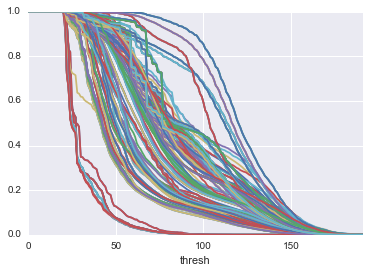

In [24]:
df_count.apply(lambda row: row/float(row.loc[0]),axis=1).T.plot.line(legend=False)

# Models

In [4]:
data_dict = icu_data_defs.data_dictionary('config/data_definitions.xlsx')

In [5]:
df_features = utils.read_and_reconstruct('data/data_sets.h5','all/train_subset/features')
df_labels = utils.read_and_reconstruct('data/data_sets.h5','all/train_subset/labels')

In [6]:
y_next = df_labels.loc[df_features.index,['NEXT_LACTATE']].iloc[:,0].dropna()
y_delta = df_labels.loc[df_features.index,['DELTA_LACTATE']].iloc[:,0].dropna()
y_delta_dir = (y_delta / y_delta.abs()).fillna(0)
X_next = df_features.loc[y_next.index]
X_delta = df_features.loc[y_delta.index]
X_next_no_lac = X_next.loc[:,X_next.columns.get_level_values(column_names.COMPONENT) != data_dict.components.LACTATE]
X_delta_no_lac = X_delta.loc[:,X_next.columns.get_level_values(column_names.COMPONENT) != data_dict.components.LACTATE]

In [7]:
print "Next Lactate:",X_next.shape,y_next.shape
print "Delta Lactate:",X_delta.shape,y_delta.shape

Next Lactate: (20267, 264) (20267L,)
Delta Lactate: (18563, 264) (18563L,)


In [10]:
#if I need test & train:
train_ids_next,test_ids_next = train_test_split(
    y_next.index.get_level_values(column_names.ID).unique().tolist(),
    test_size=.1,
    random_state=random_state
)
train_ids_delta,test_ids_delta = train_test_split(
    y_delta.index.get_level_values(column_names.ID).unique().tolist(),
    test_size=.1,
    random_state=random_state
)

## Linear Regression

In [11]:
scaler = StandardScaler()
lin_reg = LinearRegression()
pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('model',lin_reg)
    ])

### Next Lactate

In [65]:
run_crossval(pipeline,X_next,y_next)

Cross Validation, K-Fold
R^2: -7.57338573218e+22, 7.72034126296e+22, [0.83056069812417488, 0.80129359315144733, -2.0832494787516588e+23, 0.75829996680217104, -1.0092783866563815e+23, -5.3836686952272639e+22, -5.3931066579882309e+22, -2.2274170795298564e+23, -8.1604984799375898e+22, -3.5971340392807558e+22]
RMSE: 6.00806531779e+11, 4.86099034196e+11, [-2.2474652874788532, -1.5110524953853575, -1.7299417997624521e+24, -1.9422164549104937, -6.5815897370487276e+23, -2.259069711285713e+23, -2.6144746520224727e+23, -1.8690449682432424e+24, -8.8099259332066197e+23, -3.4711482538591736e+23]

Cross Validation, ShuffleSplit
R^2: -2.00690192378e+23, 5.28823217702e+23, [-1.9958280470095908e+21, 0.71662690587680844, -2.0629413124461863e+23, -1.0387167185426824e+22, -2.8018761213919232, -2.2059639824343904e+19, -6.8918820607882732e+19, -1.7766554493241807e+24, -1.1478369514826485e+22, 0.75751463962802201]
RMSE: 9.37786475925e+11, 1.2381869756e+12, [-6.1276190467676778e+22, -1.6998423302043939, -2.50

In [66]:
X_next_known = X_next.loc[:,X_next.columns.get_level_values('status') == 'known']
X_next_known.shape

(20267, 192)

In [67]:
run_crossval(pipeline,X_next_known,y_next)

Cross Validation, K-Fold
R^2: 0.706178267694, 0.10517158835, [0.82278553108697838, 0.7955658775366854, 0.79447055302984038, 0.74666792910212509, 0.70442956572236692, 0.61968186070247189, 0.62367914062690266, 0.75924413840877958, 0.4581377458849788, 0.73712033484067541]
RMSE: 1.49481717799, 0.3251547074, [-2.3505961303647331, -1.554608609704007, -1.7067278068337612, -2.0356874185933043, -1.9274398050485642, -1.595873070535069, -1.8243313367462493, -2.0202032920440542, -5.8498464726020387, -2.5367258509925472]

Cross Validation, ShuffleSplit
R^2: 0.747006214631, 0.0552031148036, [0.66924706161802083, 0.78301931366490574, 0.7928271874356293, 0.79460876515379864, 0.75605782646517117, 0.80341605072749078, 0.70143991221744484, 0.73965870361261143, 0.63970011845328112, 0.7900872069587257]
RMSE: 1.33657653909, 0.0863547540306, [-1.5269286027165017, -2.1175283829441973, -2.1489163261259963, -1.636348585481894, -1.8546550420908263, -1.6286063403690096, -1.8891737014542498, -2.0254493775614741, -

In [68]:
X_next_no_lac_known = X_next_no_lac.loc[:,X_next_no_lac.columns.get_level_values('status') == 'known']
X_next_no_lac_known.shape

(20267, 188)

In [69]:
run_crossval(pipeline,X_next_no_lac_known,y_next)

Cross Validation, K-Fold
R^2: 0.315325269978, 0.185641333452, [0.55106811954649326, 0.50549940871694643, 0.49625078607904138, 0.34269198073971185, 0.35195458791850909, 0.097152082566815734, 0.2176590292493068, 0.080267889412189319, 0.033455498971844078, 0.47725331657976111]
RMSE: 2.29267898037, 0.402497292011, [-5.954691778069801, -3.7604039259654862, -4.1831611175131309, -5.2818960513217768, -4.2259589521450547, -3.7884879245612493, -3.7926389500135231, -7.7175518192072072, -10.434638871804955, -5.0443803804643617]

Cross Validation, ShuffleSplit
R^2: 0.41476705283, 0.103972720818, [0.44420797549955693, 0.41374452930895222, 0.4469529025134894, 0.45159277091966032, 0.43897077859266387, 0.48300611136113847, 0.49234919562913404, 0.37771965346300951, 0.4807616718080493, 0.11836493920293989]
RMSE: 2.24563968784, 0.325250791357, [-4.8701172849355592, -3.9762039276520991, -10.087717372071143, -4.0232921840108586, -4.7347289939265416, -5.4119162995243011, -4.6854575417785647, -4.8843557114918

In [70]:
pipeline.fit(X_next_no_lac_known,y_next)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [71]:
pd.Series(lin_reg.coef_,index=X_next_no_lac_known.columns).sort_values().to_frame()

0
feature  component                                   status variable_type units      description          
COUNT    partial pressure of oxygen arterial         known  qn            mmHg       all         -2.990184
LAST     alkaline phosphatase serum                  known  qn            IU/L       all         -2.899350
MEAN_QN  phosphorous serum                           known  qn            mg/dL      all         -2.743561
LAST     bicarbonate other                           known  qn            mEq/L      all         -2.466549
COUNT    blood pressure systolic                     known  qn            mmHg       all         -2.383972
LAST     blood urea nitrogen serum                   known  qn            mg/dL      all         -2.308263
         magnesium serum                             known  qn            mg/dL      all         -2.305865
         creatinine serum                            known  qn            mg/dL      all         -1.420166
         mean corpuscular volume                     known  qn            fL         all         -1.309496
COUNT    international normalized ratio              known  qn            no_units   all         -1.232670
LAST     platelet count                              known  qn            x10e3/uL   all         -0.909758
COUNT    respiratory rate                            known  qn            insp/min   all         -0.881174
MEAN_QN  hematocrit                                  known  qn            percent    all         -0.782599
MEAN_ORD glasgow coma scale motor                    known  ord           no_units   all         -0.747987
COUNT    red cell distribution width                 known  qn            percent    all         -0.688909
MEAN_QN  prothrombin time                            known  qn            seconds    all         -0.668802
LAST     red cell distribution width                 known  qn            percent    all         -0.649186
         hemoglobin                                  known  qn            g/dL       all         -0.605593
MEAN_QN  weight body                                 known  qn            kg         all         -0.588251
LAST     fraction of inspired oxygen                 known  qn            percent    all         -0.543099
SUM      mean corpuscular hemoglobin                 known  qn            pg         all         -0.473550
COUNT    positive end expiratory pressure            known  qn            cmH2O      all         -0.402325
MEAN_QN  mean corpuscular hemoglobin                 known  qn            pg         all         -0.377658
COUNT    output urine                                known  qn            mL         all         -0.354982
         blood urea nitrogen serum                   known  qn            mg/dL      all         -0.329025
MEAN_QN  glucose serum                               known  qn            mg/dL      all         -0.319254
LAST     vasopressin                                 known  qn            units      all         -0.312370
         international normalized ratio              known  qn            no_units   all         -0.300723
MEAN_QN  red blood cell count                        known  qn            x10e6/uL   all         -0.300447
         calcium ionized serum                       known  qn            mmol/L     all         -0.296749
...                                                                                                    ...
LAST     red blood cell count                        known  qn            x10e6/uL   all          0.298955
COUNT    vasopressin                                 known  qn            units/min  all          0.304819
         creatinine serum                            known  qn            mg/dL      all          0.307498
MEAN_QN  vasopressin                                 known  qn            units      all          0.372849
COUNT    tidal volume                                known  qn            mL         all          0.394498
LAST     norepinephrine                

In [72]:
pd.Series(lin_reg.coef_,index=X_next_no_lac_known.columns).abs().sort_values(ascending=False).to_frame()

0
feature  component                                   status variable_type units     description          
COUNT    partial pressure of carbon dioxide arterial known  qn            mmHg      all          3.233393
MEAN_QN  alkaline phosphatase serum                  known  qn            IU/L      all          3.046241
COUNT    partial pressure of oxygen arterial         known  qn            mmHg      all          2.990184
LAST     phosphorous serum                           known  qn            mg/dL     all          2.904834
         alkaline phosphatase serum                  known  qn            IU/L      all          2.899350
MEAN_QN  phosphorous serum                           known  qn            mg/dL     all          2.743561
COUNT    blood pressure diastolic                    known  qn            mmHg      all          2.616448
LAST     bicarbonate other                           known  qn            mEq/L     all          2.466549
COUNT    blood pressure systolic                     known  qn            mmHg      all          2.383972
MEAN_QN  magnesium serum                             known  qn            mg/dL     all          2.369418
LAST     blood urea nitrogen serum                   known  qn            mg/dL     all          2.308263
         magnesium serum                             known  qn            mg/dL     all          2.305865
MEAN_QN  bicarbonate other                           known  qn            mEq/L     all          2.091229
         blood urea nitrogen serum                   known  qn            mg/dL     all          1.969064
         mean corpuscular volume                     known  qn            fL        all          1.467640
         creatinine serum                            known  qn            mg/dL     all          1.440393
COUNT    prothrombin time                            known  qn            seconds   all          1.435332
LAST     creatinine serum                            known  qn            mg/dL     all          1.420166
         mean corpuscular volume                     known  qn            fL        all          1.309496
COUNT    international normalized ratio              known  qn            no_units  all          1.232670
         heart rate                                  known  qn            beats/min all          1.107469
SUM      mean corpuscular volume                     known  qn            fL        all          0.985446
LAST     prothrombin time                            known  qn            seconds   all          0.917911
         platelet count                              known  qn            x10e3/uL  all          0.909758
COUNT    respiratory rate                            known  qn            insp/min  all          0.881174
MEAN_QN  hematocrit                                  known  qn            percent   all          0.782599
         hemoglobin                                  known  qn            g/dL      all          0.778000
MEAN_ORD glasgow coma scale motor                    known  ord           no_units  all          0.747987
MEAN_QN  red cell distribution width                 known  qn            percent   all          0.731552
COUNT    red cell distribution width                 known  qn            percent   all          0.688909
...                                                                                                   ...
STD      normal saline                               known  qn            mL/hr     all          0.020501
COUNT    pH arterial                                 known  qn            no_units  all          0.018971
MEAN_QN  calcium total serum                         known  qn            mg/dL     all          0.018913
STD      heart rate                                  known  qn            beats/min all          0.015243
         glasgow coma scale verbal                   known  ord           no_units  all          0.015061
LAST     heart rate                                  known  qn            be

### Delta Lactate

In [73]:
run_crossval(pipeline,X_delta,y_delta)

Cross Validation, K-Fold
R^2: -4.42490910877e+24, 1.16004386357e+25, [0.18539578256696165, 0.1863723379372948, 0.12238207300289694, 0.14409663214983981, -2.3023864868164465, -3.8961533625274928e+25, -4.4765901282298819e+23, -0.077933529564172765, -4.8268312407782157e+24, -1.3067208780809574e+22]
RMSE: 1.18854666019e+12, 2.44499365967e+12, [-2.072608871931823, -1.4279041958765555, -1.6627797158587307, -2.0949396016612369, -6.8958834141305685, -6.5793600586458556e+25, -7.7492753821503284e+23, -1.5431560385821166, -7.3010583793358416e+24, -3.6785088569395867e+22]

Cross Validation, ShuffleSplit
R^2: -1.3119401416e+26, 3.92758832628e+26, [0.13461144573249617, 0.1833626872333205, 0.055624843898550491, 0.14138093307937505, 0.12964451119137443, 0.17059825530223083, -2.4717035406518886e+24, -1.309468438055816e+27, 0.070616892678005305, 0.083045292189327102]
RMSE: 1.11319004084e+12, 1.9525172545e+12, [-1.6811037224772289, -3.9992242786521322e+25, -1.5967991994195876, -1.4304665890250376, -3.692

In [74]:
X_delta_known = X_delta.loc[:,X_delta.columns.get_level_values('status') == 'known']
print X_delta_known.shape
X_delta_no_lac_known = X_delta_no_lac.loc[:,X_delta_no_lac.columns.get_level_values('status') == 'known']
X_delta_no_lac_known.shape

(18563, 192)


(18563, 188)

In [75]:
run_crossval(pipeline,X_delta_known,y_delta)

Cross Validation, K-Fold
R^2: -1.21744949569e+22, 3.65234848707e+22, [0.14342938087158696, 0.16023660599298339, 0.068045167029559539, 0.1128291179533143, -2.5628723539897074, 0.15654511577054087, -1.2174494956895469e+23, -0.22493445852058724, 0.017910136950423095, 0.14652548151609091]
RMSE: 45907364176.9, 1.37722092526e+11, [-2.1793845730827175, -1.473772008692771, -1.7657291911322535, -2.1714710842985081, -7.4398173777131147, -1.4243262161962469, -2.1074860855507532e+23, -1.7536007134852056, -1.4855077930428862, -2.402589281366637]

Cross Validation, ShuffleSplit
R^2: -4.93687880753e+22, 1.48106364226e+23, [0.18063962638697928, 0.16524128995482912, 0.089002656065932273, 0.17585074275279167, 0.087906511332444204, 0.13187088613506182, 0.15527629541046306, 0.14101092692432748, -4.9368788075339139e+23, -0.049190804726641613]
RMSE: 1.34514655889, 0.143050651342, [-1.51544246908883, -2.9520675752633827, -1.7777212331646235, -1.7772774218060614, -1.4182119177944077, -1.4963074132637493, -1.7

In [76]:
pipeline.fit(X_delta_known,y_delta)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [77]:
pd.Series(lin_reg.coef_,index=X_delta_known.columns).sort_values().to_frame()

0
feature  component                                   status variable_type units     description          
LAST     blood urea nitrogen serum                   known  qn            mg/dL     all         -2.478411
         bicarbonate other                           known  qn            mEq/L     all         -2.233776
MEAN_QN  alkaline phosphatase serum                  known  qn            IU/L      all         -1.917882
COUNT    blood pressure systolic                     known  qn            mmHg      all         -1.082388
MEAN_QN  red cell distribution width                 known  qn            percent   all         -1.054315
COUNT    partial pressure of oxygen arterial         known  qn            mmHg      all         -0.848891
MEAN_QN  creatinine serum                            known  qn            mg/dL     all         -0.823223
         phosphorous serum                           known  qn            mg/dL     all         -0.813544
         lactate                                     known  qn            mmol/L    all         -0.613202
LAST     platelet count                              known  qn            x10e3/uL  all         -0.596036
MEAN_QN  glucose serum                               known  qn            mg/dL     all         -0.503297
COUNT    international normalized ratio              known  qn            no_units  all         -0.484389
MEAN_ORD glasgow coma scale motor                    known  ord           no_units  all         -0.446841
COUNT    mean corpuscular volume                     known  qn            fL        all         -0.438810
         mean corpuscular hemoglobin                 known  qn            pg        all         -0.438810
LAST     magnesium serum                             known  qn            mg/dL     all         -0.422640
         bicarbonate arterial                        known  qn            mEq/L     all         -0.404924
         hemoglobin                                  known  qn            g/dL      all         -0.396102
         glasgow coma scale eye opening              known  ord           no_units  all         -0.353778
COUNT    bicarbonate arterial                        known  qn            mEq/L     all         -0.327491
MEAN_QN  calcium total serum                         known  qn            mg/dL     all         -0.297426
         red blood cell count                        known  qn            x10e6/uL  all         -0.259664
COUNT    blood pressure mean                         known  qn            mmHg      all         -0.209097
MEAN_QN  mean corpuscular volume                     known  qn            fL        all         -0.193676
         hematocrit                                  known  qn            percent   all         -0.181813
         prothrombin time                            known  qn            seconds   all         -0.169126
COUNT    respiratory rate                            known  qn            insp/min  all         -0.163655
LAST     calcium ionized serum                       known  qn            mmol/L    all         -0.162306
MEAN_QN  mean corpuscular hemoglobin                 known  qn            pg        all         -0.161241
LAST     partial thromboplastin time                 known  qn            seconds   all         -0.150669
...                                                                                                   ...
         mean corpuscular hemoglobin                 known  qn            pg        all          0.129045
COUNT    glasgow coma scale eye opening              known  ord           no_units  all          0.136068
MEAN_QN  international normalized ratio              known  qn            no_units  all          0.156790
         sodium serum                                known  qn            mEq/L     all          0.166975
COUNT    hemoglobin                                  known  qn            g/dL      all          0.180672
LAST     mean corpuscular volume                     known  qn            fL

In [78]:
pd.Series(lin_reg.coef_,index=X_delta_known.columns).abs().sort_values(ascending=False).to_frame()

0
feature  component                                   status variable_type units      description          
LAST     blood urea nitrogen serum                   known  qn            mg/dL      all          2.478411
MEAN_QN  blood urea nitrogen serum                   known  qn            mg/dL      all          2.452236
LAST     bicarbonate other                           known  qn            mEq/L      all          2.233776
MEAN_QN  bicarbonate other                           known  qn            mEq/L      all          2.185893
LAST     alkaline phosphatase serum                  known  qn            IU/L       all          1.959678
MEAN_QN  alkaline phosphatase serum                  known  qn            IU/L       all          1.917882
COUNT    partial pressure of carbon dioxide arterial known  qn            mmHg       all          1.336434
         blood pressure diastolic                    known  qn            mmHg       all          1.275404
LAST     red cell distribution width                 known  qn            percent    all          1.096981
COUNT    blood pressure systolic                     known  qn            mmHg       all          1.082388
MEAN_QN  red cell distribution width                 known  qn            percent    all          1.054315
COUNT    partial pressure of oxygen arterial         known  qn            mmHg       all          0.848891
LAST     phosphorous serum                           known  qn            mg/dL      all          0.846699
MEAN_QN  creatinine serum                            known  qn            mg/dL      all          0.823223
         phosphorous serum                           known  qn            mg/dL      all          0.813544
LAST     creatinine serum                            known  qn            mg/dL      all          0.782700
MEAN_QN  lactate                                     known  qn            mmol/L     all          0.613202
LAST     platelet count                              known  qn            x10e3/uL   all          0.596036
MEAN_QN  platelet count                              known  qn            x10e3/uL   all          0.547433
COUNT    prothrombin time                            known  qn            seconds    all          0.524210
LAST     glucose serum                               known  qn            mg/dL      all          0.511826
MEAN_QN  glucose serum                               known  qn            mg/dL      all          0.503297
COUNT    red cell distribution width                 known  qn            percent    all          0.485766
         international normalized ratio              known  qn            no_units   all          0.484389
MEAN_ORD glasgow coma scale eye opening              known  ord           no_units   all          0.460086
MEAN_QN  magnesium serum                             known  qn            mg/dL      all          0.456271
MEAN_ORD glasgow coma scale motor                    known  ord           no_units   all          0.446841
COUNT    mean corpuscular volume                     known  qn            fL         all          0.438810
         mean corpuscular hemoglobin                 known  qn            pg         all          0.438810
LAST     magnesium serum                             known  qn            mg/dL      all          0.422640
...                                                                                                    ...
STD      lactated ringers                            known  qn            mL         all          0.009124
MEAN_QN  output urine                                known  qn            mL         all          0.008944
COUNT    pH arterial                                 known  qn            no_units   all          0.008527
         red blood cell count                        known  qn            x10e6/uL   all          0.008382
MEAN_QN  blood pressure systolic                     known  qn            mmHg       all          0.008315
STD      central venous oxygen saturati

In [79]:
# Delta, no lactate
run_crossval(pipeline,X_delta_no_lac_known,y_delta)

Cross Validation, K-Fold
R^2: -0.577282500293, 1.77817895647, [0.01138818384379503, 0.083874882556315145, 0.010901990577526943, 0.0073844188094479568, -5.9107901206792626, 0.052368727411629235, -0.037316285488910861, -0.037724549157442278, 0.011090263836369907, 0.035997485365176218]
RMSE: 1.62746591409, 0.739057902316, [-2.5153388322966963, -1.6077856741366832, -1.873995569679566, -2.4295612897110566, -14.430777003835995, -1.6002469012531524, -1.795663512715062, -1.485593369625188, -1.4958235238529272, -2.7137331680228467]

Cross Validation, ShuffleSplit
R^2: -1.04806660876e+21, 3.14419982629e+21, [-0.01586653632881907, 0.029217689965005733, 0.047366718465182589, 0.006783613497672647, -0.03485629413682112, 0.013165856887549565, 0.0611258889942492, -1.0480666087620327e+22, 0.026213355467124111, 0.047118966885235314]
RMSE: 1.41398315228, 0.11347090348, [-2.2514474254989842, -1.8832944332826853, -2.0208565072547651, -1.6128582657419084, -2.7202068231278242, -2.106207817953818, -2.27339168

In [80]:
pipeline.fit(X_delta_no_lac_known,y_delta)
coef_abs = pd.Series(lin_reg.coef_,index=X_delta_no_lac_known.columns).abs().sort_values(ascending=False).to_frame()
coef_abs

0
feature  component                                   status variable_type units      description          
LAST     alkaline phosphatase serum                  known  qn            IU/L       all          2.994218
MEAN_QN  alkaline phosphatase serum                  known  qn            IU/L       all          2.980967
         blood urea nitrogen serum                   known  qn            mg/dL      all          2.487813
LAST     blood urea nitrogen serum                   known  qn            mg/dL      all          2.424465
MEAN_QN  bicarbonate other                           known  qn            mEq/L      all          2.061441
LAST     bicarbonate other                           known  qn            mEq/L      all          2.029759
MEAN_QN  creatinine serum                            known  qn            mg/dL      all          1.466464
LAST     creatinine serum                            known  qn            mg/dL      all          1.408530
         red cell distribution width                 known  qn            percent    all          1.352608
MEAN_QN  red cell distribution width                 known  qn            percent    all          1.321007
COUNT    blood pressure diastolic                    known  qn            mmHg       all          0.979189
         red cell distribution width                 known  qn            percent    all          0.873394
         partial pressure of carbon dioxide arterial known  qn            mmHg       all          0.845753
         blood pressure systolic                     known  qn            mmHg       all          0.785178
MEAN_QN  mean corpuscular volume                     known  qn            fL         all          0.750015
LAST     mean corpuscular volume                     known  qn            fL         all          0.726559
MEAN_QN  glucose serum                               known  qn            mg/dL      all          0.565066
COUNT    mean corpuscular hemoglobin                 known  qn            pg         all          0.541477
         mean corpuscular volume                     known  qn            fL         all          0.541477
MEAN_QN  bicarbonate arterial                        known  qn            mEq/L      all          0.532244
LAST     bicarbonate arterial                        known  qn            mEq/L      all          0.500282
         glucose serum                               known  qn            mg/dL      all          0.500052
MEAN_ORD glasgow coma scale eye opening              known  ord           no_units   all          0.459524
MEAN_QN  platelet count                              known  qn            x10e3/uL   all          0.454835
LAST     platelet count                              known  qn            x10e3/uL   all          0.434971
COUNT    bicarbonate arterial                        known  qn            mEq/L      all          0.432579
MEAN_QN  calcium total serum                         known  qn            mg/dL      all          0.394361
LAST     calcium total serum                         known  qn            mg/dL      all          0.372772
         glasgow coma scale eye opening              known  ord           no_units   all          0.351652
         hemoglobin                                  known  qn            g/dL       all          0.335277
...                                                                                                    ...
STD      lactated ringers                            known  qn            mL         all          0.010732
         blood pressure mean                         known  qn            mmHg       all          0.010673
MEAN_QN  oxygen saturation arterial                  known  qn            percent    all          0.010192
STD      vasopressin                                 known  qn            units/min  all          0.010040
         blood pressure diastolic                    known  qn            mmHg       all          0.008892
COUNT    phosphorous serum             

In [81]:
column_subset = coef_abs.loc[coef_abs[0] > 0.1].index

In [82]:
run_crossval(pipeline,X_delta_no_lac_known.loc[:,column_subset],y_delta)

Cross Validation, K-Fold
R^2: -0.822960319936, 2.53101313462, [0.045326196482469383, 0.074908720774553683, -0.0024347220290164007, 0.013825443055806019, -8.4153517148528394, 0.048413647527979387, -0.028828943578103283, -0.035565365155825202, 0.03696025471804798, 0.033143283700834969]
RMSE: 1.68749805489, 0.927287188567, [-2.4289898733969926, -1.6235211519554036, -1.8992639860555578, -2.4137960091013442, -19.660681143123963, -1.6069257694069354, -1.7809713591237477, -1.4825023090550129, -1.4566926107801168, -2.721767941384079]

Cross Validation, ShuffleSplit
R^2: 0.0211545361393, 0.0258777120295, [0.023770720202128115, 0.01578799949861498, 0.043522312328604706, 0.015834679716753008, 0.061125854614448305, 0.02258718828748596, -0.038036735884840134, 0.028884242643845814, 0.040945675687134586, -0.0028765757016300242]
RMSE: 1.37440225479, 0.127304754145, [-1.7947471875106613, -2.51824032755178, -1.4827905166110136, -1.5752130138309364, -1.9252657451966466, -1.4495728071765255, -1.9400898977

Clearly I am having some issues with this data set.
R^2 for K-fold and shuffle split CV are not really correlating and, moreover, i am getting significantly negative R^2; yet the RMSE is low? so I don't trust my results



In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

In [48]:
pipeline.fit(X_delta_no_lac_known,y_delta)
y_delta_pred = pipeline.predict(X_delta_no_lac_known)

In [50]:
np.sqrt(mean_squared_error(y_delta, y_delta_pred))

1.3553208898763829

In [51]:
r2_score(y_delta, y_delta_pred)

0.077660384815361971

## Elastic Net

In [86]:
from sklearn.linear_model import ElasticNetCV,ElasticNet
# more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge); more L1
elastic_net_cv = ElasticNetCV(l1_ratio=[0,.01,.1, .5, .7,.9, .95, .99, 1])
pipeline_enet_cv = Pipeline([
        ('scaler',StandardScaler()),
        ('model',elastic_net_cv)
    ])

In [ ]:
enet = ElasticNet(l1_ratio=0.1)
pipeline_enet = Pipeline([
        ('scaler',StandardScaler()),
        ('model',enet)
    ])

### Next Lactate

In [87]:
pipeline_enet_cv.fit(X_next_no_lac,y_next)
print elastic_net_cv.l1_ratio_ 
pd.Series(elastic_net_cv.coef_,index=X_next_no_lac.columns).sort_values().to_frame()

0.1


0
feature  component                                   status  variable_type units      description          
LAST     chloride serum                              unknown qn            mEq/L      all         -0.544238
MEAN_QN  chloride serum                              unknown qn            mEq/L      all         -0.527066
LAST     bicarbonate arterial                        known   qn            mEq/L      all         -0.297295
         bicarbonate other                           known   qn            mEq/L      all         -0.296842
MEAN_QN  bicarbonate arterial                        known   qn            mEq/L      all         -0.296639
         bicarbonate other                           known   qn            mEq/L      all         -0.289677
LAST     blood urea nitrogen serum                   known   qn            mg/dL      all         -0.150024
MEAN_QN  blood urea nitrogen serum                   known   qn            mg/dL      all         -0.141234
COUNT    output urine                                known   qn            mL         all         -0.140334
LAST     platelet count                              known   qn            x10e3/uL   all         -0.133712
MEAN_QN  platelet count                              known   qn            x10e3/uL   all         -0.128436
LAST     creatinine serum                            known   qn            mg/dL      all         -0.103035
MEAN_ORD glasgow coma scale motor                    known   ord           no_units   all         -0.098536
MEAN_QN  creatinine serum                            known   qn            mg/dL      all         -0.096566
         oxygen saturation pulse oximetry            known   qn            percent    all         -0.085415
LAST     oxygen saturation pulse oximetry            known   qn            percent    all         -0.083936
MEAN_QN  mean corpuscular hemoglobin concentration   unknown qn            percent    all         -0.061537
         calcium ionized serum                       known   qn            mmol/L     all         -0.059125
         temperature body                            known   qn            degF       all         -0.055733
LAST     mean corpuscular hemoglobin concentration   unknown qn            percent    all         -0.053502
MEAN_QN  blood pressure systolic                     known   qn            mmHg       all         -0.051468
         hematocrit                                  known   qn            percent    all         -0.049250
LAST     glasgow coma scale motor                    known   ord           no_units   all         -0.048272
COUNT    weight body                                 known   qn            kg         all         -0.042889
LAST     blood pressure systolic                     known   qn            mmHg       all         -0.041544
MEAN_QN  blood pressure mean                         known   qn            mmHg       all         -0.040502
COUNT    phosphorous serum                           known   qn            mg/dL      all         -0.034840
STD      partial pressure of carbon dioxide arterial known   qn            mmHg       all         -0.029689
MEAN_QN  vasopressin                                 known   qn            units/min  all         -0.029275
COUNT    glucose fingerstick                         unknown qn            no_units   all         -0.028263
...                                                                                                     ...
MEAN_QN  potassium serum                             known   qn            mEq/L      all          0.055137
LAST     prothrombin time                            known   qn            seconds    all          0.059883
COUNT    partial pressure of oxygen arterial         known   qn            mmHg       all          0.061283
         partial pressure of carbon dioxide arterial known   qn            mmHg       all          0.065514
MEAN_QN  alanine aminotransferase serum              unknown qn            IU/L       all          0.067310
LA

In [103]:
#include lactate
X=X_next
y=y_next

pipeline_enet.fit(X,y)
y_pred = pipeline_enet.predict(X)
print 'R^2:',r2_score(y, y_pred)
print 'RMSE:',np.sqrt(mean_squared_error(y, y_pred))
pd.Series(enet.coef_,index=X.columns).abs().sort_values(ascending=False).to_frame()

R^2: 0.713177368099
RMSE: 1.53557050279


,,,,,,0
feature,component,status,variable_type,units,description,
LAST,lactate,known,qn,mmol/L,all,0.658925
MEAN_QN,lactate,known,qn,mmol/L,all,0.648812
LAST,bicarbonate arterial,known,qn,mEq/L,all,0.079476
MEAN_QN,bicarbonate arterial,known,qn,mEq/L,all,0.077081
LAST,bicarbonate other,known,qn,mEq/L,all,0.070986
MEAN_QN,bicarbonate other,known,qn,mEq/L,all,0.069797
LAST,chloride serum,unknown,qn,mEq/L,all,0.068503
MEAN_QN,chloride serum,unknown,qn,mEq/L,all,0.066257
LAST,norepinephrine,known,qn,mcg/kg/min,all,0.064092


In [102]:
#no lactate
X=X_next_no_lac
y=y_next

pipeline_enet.fit(X,y)
y_pred = pipeline_enet.predict(X)
print 'R^2:',r2_score(y, y_pred)
print 'RMSE:',np.sqrt(mean_squared_error(y, y_pred))
pd.Series(enet.coef_,index=X.columns).abs().sort_values(ascending=False).to_frame()

R^2: 0.467102597658
RMSE: 2.093075308


0
feature       component                                   status  variable_type units      description                           
MEAN_QN       bicarbonate arterial                        known   qn            mEq/L      all                           0.173893
LAST          chloride serum                              unknown qn            mEq/L      all                           0.173196
              bicarbonate arterial                        known   qn            mEq/L      all                           0.171251
MEAN_QN       chloride serum                              unknown qn            mEq/L      all                           0.171212
LAST          bicarbonate other                           known   qn            mEq/L      all                           0.149283
MEAN_QN       bicarbonate other                           known   qn            mEq/L      all                           0.148160
COUNT         vasopressin                                 known   qn            units/min  all                           0.112246
LAST          norepinephrine                              known   qn            mcg/kg/min all                           0.110967
              aspartate aminotransferase serum            unknown qn            IU/L       all                           0.101676
MEAN_QN       aspartate aminotransferase serum            unknown qn            IU/L       all                           0.101609
              norepinephrine                              known   qn            mcg/kg/min all                           0.099697
SUM           norepinephrine                              known   qn            mcg        all                           0.095657
MEAN_QN       phosphorous serum                           unknown qn            mEq/L      all                           0.094704
LAST          phosphorous serum                           unknown qn            mEq/L      all                           0.090167
              sodium serum                                known   qn            mEq/L      all                           0.089831
MEAN_QN       sodium serum                                known   qn            mEq/L      all                           0.088578
              norepinephrine                              known   qn            mcg        all                           0.077202
              alanine aminotransferase serum              unknown qn            IU/L       all                           0.075221
LAST          alanine aminotransferase serum              unknown qn            IU/L       all                           0.075203
MEAN_QN       oxygen saturation pulse oximetry            known   qn            percent    all                           0.073315
LAST          norepinephrine                              known   qn            mcg        all                           0.073049
              partial thromboplastin time                 known   qn            seconds    all                           0.069818
MEAN_QN       partial thromboplastin time                 known   qn            seconds    all                           0.069529
LAST          oxygen saturation pulse oximetry            known   qn            percent    all                           0.069032
COUNT         partial pressure of carbon dioxide arterial known   qn            mmHg       all                           0.068040
              bicarbonate arterial                        known   qn            mEq/L      all                           0.067907
              partial pressure of oxygen arterial         known   qn            mmHg       all                           0.067340
              pH arterial                                 unknown qn            units      all                           0.067289
LAST          prothrombin time                            known   qn            seconds    all                           0.067190
              platelet count                              known   qn            x10e3/uL   all    

In [104]:
#no unknown
X=X_next_no_lac_known
y=y_next

pipeline_enet.fit(X,y)
y_pred = pipeline_enet.predict(X)
print 'R^2:',r2_score(y, y_pred)
print 'RMSE:',np.sqrt(mean_squared_error(y, y_pred))
pd.Series(enet.coef_,index=X.columns).abs().sort_values(ascending=False).to_frame()

R^2: 0.402829516053
RMSE: 2.21570643856


0
feature component                                   status variable_type units      description          
MEAN_QN bicarbonate arterial                        known  qn            mEq/L      all          0.158038
LAST    bicarbonate arterial                        known  qn            mEq/L      all          0.154725
        bicarbonate other                           known  qn            mEq/L      all          0.137105
MEAN_QN bicarbonate other                           known  qn            mEq/L      all          0.135841
LAST    norepinephrine                              known  qn            mcg/kg/min all          0.131882
COUNT   vasopressin                                 known  qn            units/min  all          0.124949
MEAN_QN norepinephrine                              known  qn            mcg/kg/min all          0.119080
SUM     norepinephrine                              known  qn            mcg        all          0.108715
MEAN_QN calcium total serum                         known  qn            mg/dL      all          0.101843
LAST    calcium total serum                         known  qn            mg/dL      all          0.101497
        prothrombin time                            known  qn            seconds    all          0.101187
MEAN_QN prothrombin time                            known  qn            seconds    all          0.100211
        oxygen saturation pulse oximetry            known  qn            percent    all          0.096648
        norepinephrine                              known  qn            mcg        all          0.091954
LAST    norepinephrine                              known  qn            mcg        all          0.087218
        oxygen saturation pulse oximetry            known  qn            percent    all          0.086323
COUNT   partial pressure of carbon dioxide arterial known  qn            mmHg       all          0.083635
        bicarbonate arterial                        known  qn            mEq/L      all          0.083227
        partial pressure of oxygen arterial         known  qn            mmHg       all          0.082822
        output urine                                known  qn            mL         all          0.082410
LAST    partial thromboplastin time                 known  qn            seconds    all          0.072381
MEAN_QN partial thromboplastin time                 known  qn            seconds    all          0.072249
LAST    platelet count                              known  qn            x10e3/uL   all          0.070922
MEAN_QN platelet count                              known  qn            x10e3/uL   all          0.069625
LAST    glucose serum                               known  qn            mg/dL      all          0.068308
MEAN_QN international normalized ratio              known  qn            no_units   all          0.068172
        glucose serum                               known  qn            mg/dL      all          0.063856
LAST    glasgow coma scale motor                    known  ord           no_units   all          0.060968
        international normalized ratio              known  qn            no_units   all          0.059365
COUNT   calcium ionized serum                       known  qn            mmol/L     all          0.058734
...                                                                                                   ...
STD     vasopressin                                 known  qn            units      all          0.000000
LAST    partial pressure of carbon dioxide arterial known  qn            mmHg       all          0.000000
STD     positive end expiratory pressure            known  qn            cmH2O      all          0.000000
LAST    weight body                                 known  qn            kg         all          0.000000
        hematocrit                                  known  qn            percent    all          0.000000
STD     vasopressin                                 known  qn            uni

### Delta lactate

In [105]:
#run cv
X = X_delta_no_lac
y = y_delta

pipeline_enet_cv.fit(X,y)
print elastic_net_cv.l1_ratio_ 
pd.Series(elastic_net_cv.coef_,index=X.columns).sort_values().to_frame()

0.01


,,,,,,0
feature,component,status,variable_type,units,description,
LAST,hemoglobin,known,qn,g/dL,all,-0.043555
COUNT,pH other,unknown,qn,units,all,-0.041159
MEAN_QN,glucose serum,known,qn,mg/dL,all,-0.039892
COUNT,output urine,known,qn,mL,all,-0.038499
STD,vasopressin,known,qn,units,all,-0.034408
COUNT,fraction of inspired oxygen,unknown,qn,torr,all,-0.032692
LAST,oxygen saturation pulse oximetry,known,qn,percent,all,-0.028817
COUNT,glucose fingerstick,unknown,qn,no_units,all,-0.028618
MEAN_QN,hemoglobin,known,qn,g/dL,all,-0.025560


In [107]:
enet.l1_ratio = 0.01

In [108]:
#include lactate
X=X_delta
y=y_delta

pipeline_enet.fit(X,y)
y_pred = pipeline_enet.predict(X)
print 'R^2:',r2_score(y, y_pred)
print 'RMSE:',np.sqrt(mean_squared_error(y, y_pred))
pd.Series(enet.coef_,index=X.columns).abs().sort_values(ascending=False).to_frame()

R^2: 0.125167842053
RMSE: 1.3199548331


0
feature component                                   status  variable_type units      description          
MEAN_QN lactate                                     known   qn            mmol/L     all          0.145104
LAST    lactate                                     known   qn            mmol/L     all          0.142307
COUNT   output urine                                known   qn            mL         all          0.032426
        hemoglobin                                  known   qn            g/dL       all          0.029333
        partial pressure of carbon dioxide arterial known   qn            mmHg       all          0.029049
MEAN_QN respiratory rate                            known   qn            insp/min   all          0.029005
COUNT   partial pressure of oxygen arterial         known   qn            mmHg       all          0.028873
LAST    oxygen saturation pulse oximetry            known   qn            percent    all          0.026344
COUNT   pH arterial                                 unknown qn            units      all          0.025613
        vasopressin                                 known   qn            units/min  all          0.024768
MEAN_QN oxygen saturation pulse oximetry            known   qn            percent    all          0.023953
LAST    respiratory rate                            known   qn            insp/min   all          0.023537
COUNT   hematocrit                                  known   qn            percent    all          0.021904
SUM     norepinephrine                              known   qn            mcg        all          0.021876
LAST    norepinephrine                              known   qn            mcg/kg/min all          0.021676
        potassium serum                             known   qn            mEq/L      all          0.021073
COUNT   bicarbonate arterial                        known   qn            mEq/L      all          0.020737
LAST    hemoglobin                                  known   qn            g/dL       all          0.020324
MEAN_QN norepinephrine                              known   qn            mcg/kg/min all          0.020125
COUNT   pH other                                    unknown qn            units      all          0.019340
        glucose fingerstick                         unknown qn            no_units   all          0.018509
LAST    norepinephrine                              known   qn            mcg        all          0.018424
        pH arterial                                 unknown qn            units      all          0.016785
        red cell distribution width                 known   qn            percent    all          0.016601
SUM     output urine                                known   qn            mL         all          0.016502
MEAN_QN red cell distribution width                 known   qn            percent    all          0.016436
        phosphorous serum                           unknown qn            mEq/L      all          0.016291
        potassium serum                             known   qn            mEq/L      all          0.015980
        partial thromboplastin time                 known   qn            seconds    all          0.015881
        norepinephrine                              known   qn            mcg        all          0.015414
...                                                                                                    ...
LAST    oxygen saturation arterial                  unknown qn            no_units   all          0.000000
        glucose fingerstick                         unknown qn            no_units   all          0.000000
STD     central venous oxygen saturation            known   qn            percent    all          0.000000
LAST    mean corpuscular hemoglobin                 known   qn            pg         all          0.000000
        red blood cell count                        unknown qn            number/hpf all          0.000000
        white blood cell count         

In [109]:
#no lactate
X=X_delta_no_lac
y=y_delta

pipeline_enet.fit(X,y)
y_pred = pipeline_enet.predict(X)
print 'R^2:',r2_score(y, y_pred)
print 'RMSE:',np.sqrt(mean_squared_error(y, y_pred))
pd.Series(enet.coef_,index=X.columns).abs().sort_values(ascending=False).to_frame()

R^2: 0.0518588147173
RMSE: 1.37414704102


0
feature component                                   status  variable_type units      description          
COUNT   hemoglobin                                  known   qn            g/dL       all          0.031814
MEAN_QN respiratory rate                            known   qn            insp/min   all          0.025829
COUNT   partial pressure of carbon dioxide arterial known   qn            mmHg       all          0.024604
        partial pressure of oxygen arterial         known   qn            mmHg       all          0.024476
        output urine                                known   qn            mL         all          0.024446
MEAN_QN glucose serum                               known   qn            mg/dL      all          0.024260
LAST    hemoglobin                                  known   qn            g/dL       all          0.022589
COUNT   pH other                                    unknown qn            units      all          0.022551
LAST    potassium serum                             known   qn            mEq/L      all          0.022357
COUNT   hematocrit                                  known   qn            percent    all          0.021632
        pH arterial                                 unknown qn            units      all          0.020759
LAST    respiratory rate                            known   qn            insp/min   all          0.020446
        oxygen saturation pulse oximetry            known   qn            percent    all          0.019529
COUNT   glucose fingerstick                         unknown qn            no_units   all          0.018750
MEAN_QN oxygen saturation pulse oximetry            known   qn            percent    all          0.016904
        potassium serum                             known   qn            mEq/L      all          0.016063
        hemoglobin                                  known   qn            g/dL       all          0.015896
COUNT   fraction of inspired oxygen                 unknown qn            torr       all          0.015663
        bicarbonate arterial                        known   qn            mEq/L      all          0.015525
STD     vasopressin                                 known   qn            units      all          0.015272
SUM     output urine                                known   qn            mL         all          0.015234
MEAN_QN partial pressure of oxygen arterial         known   qn            mmHg       all          0.014643
LAST    glucose serum                               known   qn            mg/dL      all          0.014073
COUNT   central venous oxygen saturation            known   qn            percent    all          0.013549
STD     sodium serum                                known   qn            mEq/L      all          0.013523
SUM     norepinephrine                              known   qn            mcg        all          0.013458
COUNT   creatinine serum                            known   qn            mg/dL      all          0.013180
LAST    normal saline                               known   qn            mL/hr      all          0.012900
COUNT   blood urea nitrogen serum                   known   qn            mg/dL      all          0.012752
MEAN_QN blood urea nitrogen serum                   known   qn            mg/dL      all          0.012723
...                                                                                                    ...
COUNT   white blood cell count                      unknown qn            number/hpf all          0.000000
LAST    blood pressure diastolic                    unknown qn            cc/min     all          0.000000
COUNT   vasopressin                                 known   qn            units      all          0.000000
LAST    respiratory rate                            unknown qn            Breath     all          0.000000
        temperature body                            known   qn            degF       all          0.000000
        glasgow coma scale motor       

In [110]:
#no unknown
X=X_delta_no_lac_known
y=y_delta

pipeline_enet.fit(X,y)
y_pred = pipeline_enet.predict(X)
print 'R^2:',r2_score(y, y_pred)
print 'RMSE:',np.sqrt(mean_squared_error(y, y_pred))
pd.Series(enet.coef_,index=X.columns).abs().sort_values(ascending=False).to_frame()

R^2: 0.0477577004001
RMSE: 1.37711571979


0
feature  component                                   status variable_type units      description          
COUNT    hemoglobin                                  known  qn            g/dL       all          0.032243
         partial pressure of carbon dioxide arterial known  qn            mmHg       all          0.027828
         partial pressure of oxygen arterial         known  qn            mmHg       all          0.027696
MEAN_QN  glucose serum                               known  qn            mg/dL      all          0.025784
         respiratory rate                            known  qn            insp/min   all          0.025330
COUNT    output urine                                known  qn            mL         all          0.025202
LAST     potassium serum                             known  qn            mEq/L      all          0.022978
         hemoglobin                                  known  qn            g/dL       all          0.022918
COUNT    hematocrit                                  known  qn            percent    all          0.022171
LAST     respiratory rate                            known  qn            insp/min   all          0.020049
         oxygen saturation pulse oximetry            known  qn            percent    all          0.019095
COUNT    bicarbonate arterial                        known  qn            mEq/L      all          0.018048
MEAN_QN  oxygen saturation pulse oximetry            known  qn            percent    all          0.016565
         potassium serum                             known  qn            mEq/L      all          0.016524
         hemoglobin                                  known  qn            g/dL       all          0.016294
         partial pressure of oxygen arterial         known  qn            mmHg       all          0.016001
LAST     glucose serum                               known  qn            mg/dL      all          0.015474
SUM      output urine                                known  qn            mL         all          0.015372
STD      vasopressin                                 known  qn            units      all          0.015244
         sodium serum                                known  qn            mEq/L      all          0.015168
COUNT    creatinine serum                            known  qn            mg/dL      all          0.015129
         central venous oxygen saturation            known  qn            percent    all          0.015016
         blood urea nitrogen serum                   known  qn            mg/dL      all          0.014706
SUM      norepinephrine                              known  qn            mcg        all          0.013190
LAST     partial pressure of oxygen arterial         known  qn            mmHg       all          0.013102
MEAN_QN  blood urea nitrogen serum                   known  qn            mg/dL      all          0.013100
LAST     normal saline                               known  qn            mL/hr      all          0.013074
         blood urea nitrogen serum                   known  qn            mg/dL      all          0.012832
STD      calcium ionized serum                       known  qn            mmol/L     all          0.012682
COUNT    white blood cell count                      known  qn            x10e3/uL   all          0.012452
...                                                                                                    ...
STD      fraction of inspired oxygen                 known  qn            percent    all          0.000000
         bicarbonate arterial                        known  qn            mEq/L      all          0.000000
LAST     vasopressin                                 known  qn            units      all          0.000000
SUM      normal saline                               known  qn            mL         all          0.000000
         lactated ringers                            known  qn            mL         all          0.000000
STD      oxygen saturation arterial    

## Decision Trees & Random Forest

In [111]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,export_graphviz

### Classification

In [112]:
y_delta_dir = (y_delta / y_delta.abs()).fillna(0)

In [113]:
tree_clf = DecisionTreeClassifier(max_depth=5)

In [114]:
tree_clf.fit(X_delta_no_lac,y_delta_dir)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [115]:
export_graphviz(
    tree_clf,
    out_file='images/allF_lactate_delta_dir_tree.dot',
    feature_names=X_delta_no_lac.columns.tolist(),
    class_names=['decreased','unchanged','increased'],
    rounded=True,
    filled=True
)

In [119]:
%%bash
dot -Tpng images/allF_lactate_delta_dir_tree.dot -o images/allF_lactate_delta_dir_tree.png

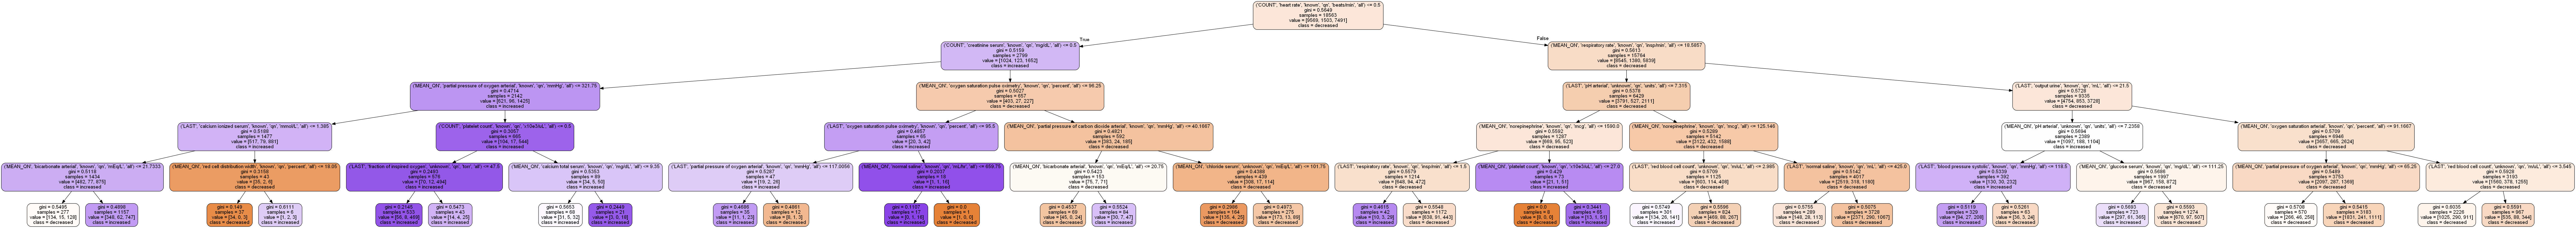

In [120]:
from IPython.display import Image
Image("images/allF_lactate_delta_dir_tree.png")

### Regression

In [121]:
tree_rgr = DecisionTreeRegressor(max_depth=5)

In [122]:
tree_rgr.fit(X_next_no_lac,y_next)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [123]:
export_graphviz(
    tree_rgr,
    out_file='images/allF_lactate_next_tree.dot',
    feature_names=X_next_no_lac.columns.tolist(),
    rounded=True,
    filled=True
)

In [124]:
%%bash
dot -Tpng images/allF_lactate_next_tree.dot -o images/allF_lactate_next_tree.png

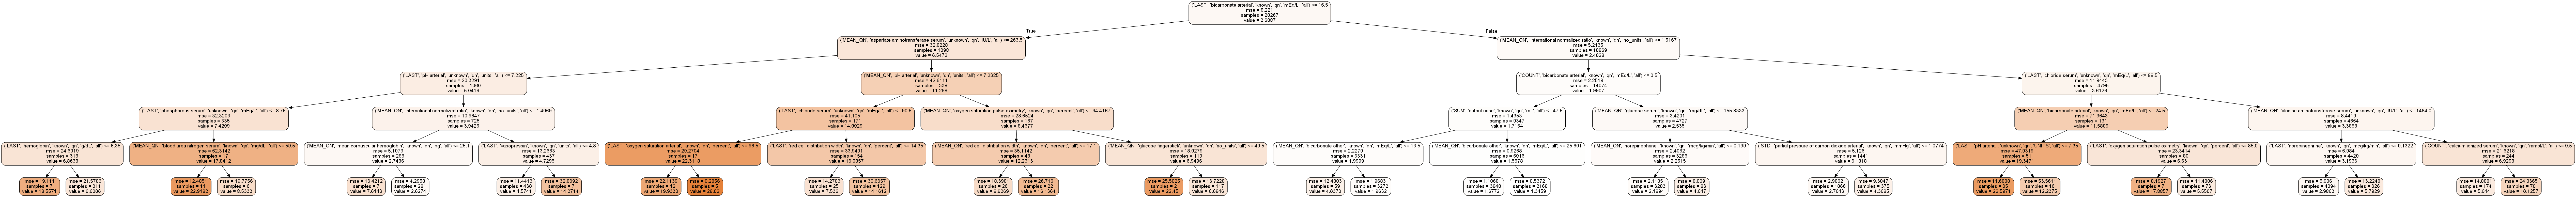

In [125]:
from IPython.display import Image
Image("images/allF_lactate_next_tree.png")

# Random Forest

In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [132]:
param_grid = {
    'max_features' : [None,100, 10],
    'max_depth' : [None,100,10],
    'max_leaf_nodes':[None,100,10]
}

In [135]:
#started at 12:23
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=500)
rfr_GSCV = GridSearchCV(rfr, param_grid)
rfr_GSCV.fit(X_next_no_lac,y_next)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 100, 10], 'max_leaf_nodes': [None, 100, 10], 'max_depth': [None, 100, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [136]:
rfr_best = rfr_GSCV.best_estimator_

In [137]:
run_crossval(rfr_best, X_next_no_lac,y_next)

Cross Validation, K-Fold
R^2: 0.545162778881, 0.0560610551177, [0.5353357199991412, 0.64419765201018853, 0.60066694165637935, 0.51164113255753052, 0.5506897060691871, 0.45447956500780218, 0.5164075808759887, 0.55792997698958691, 0.47679462083844104, 0.60348489280891227]
RMSE: 1.89493670591, 0.307660958064, [-6.0359191693608292, -2.7183859798360133, -3.3285306653695104, -3.941353490953921, -2.9787724877043904, -2.284270327420622, -2.3124564718725207, -3.7272812202764052, -5.6633306460582409, -3.8641033865016774]

Cross Validation, ShuffleSplit
R^2: 0.738968126661, 0.0322688779377, [0.79096608373049693, 0.74318863610944552, 0.78544549181875334, 0.75310586295581561, 0.72135417013610237, 0.74589170814238726, 0.72316974181240834, 0.68963846413762064, 0.69154521960418125, 0.74537588816066069]
RMSE: 1.46075071056, 0.0708159770043, [-2.409123632592403, -2.0706215392678837, -2.0806930945793773, -2.0165611329870732, -1.8817301152846566, -1.8627797710600877, -2.2587664771749383, -2.16424730851603

In [138]:
X = X_next_no_lac
y = y_next

rfr_best.fit(X,y)
y_pred = rfr_best.predict(X)
print 'R^2:',r2_score(y, y_pred)
print 'RMSE:',np.sqrt(mean_squared_error(y, y_pred))

R^2: 0.965105118898
RMSE: 0.535604126326


In [139]:
pd.Series(rfr_best.feature_importances_,index=X.columns).sort_values()

feature        component                         status   variable_type  units       description                 
COUNT_NOMINAL  output urine                      unknown  nom            no_units    3686(ml)_Voiding qs             5.042184e-09
STD            glasgow coma scale verbal         known    ord            no_units    all                             7.146657e-07
MEAN_QN        blood pressure systolic           unknown  qn             cc/min      all                             3.977447e-06
COUNT          fraction of inspired oxygen       known    qn             percent     all                             4.020769e-06
LAST           fraction of inspired oxygen       known    qn             percent     all                             5.500183e-06
STD            respiratory rate                  unknown  qn             Breath      all                             6.207046e-06
LAST           respiratory rate                  unknown  qn             Breath      all                  